In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('electric_vehicles.csv')
#df = pd.read_csv('electric_vehicles.csv')
dataset_details = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Data Types": data.dtypes.to_dict(),
    "Missing Values": data.isnull().sum().to_dict(),
    "Summary Statistics": data.describe(include='all').to_dict()
}
print(dataset_details)
# we remove data that does not have electric range

df_filtered = data[~(data["Electric Range"].isna() | (data["Electric Range"] == 0))]
df_filtered.info()



{'Shape': (223995, 17), 'Columns': ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract'], 'Data Types': {'VIN (1-10)': dtype('O'), 'County': dtype('O'), 'City': dtype('O'), 'State': dtype('O'), 'Postal Code': dtype('float64'), 'Model Year': dtype('int64'), 'Make': dtype('O'), 'Model': dtype('O'), 'Electric Vehicle Type': dtype('O'), 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': dtype('O'), 'Electric Range': dtype('float64'), 'Base MSRP': dtype('float64'), 'Legislative District': dtype('float64'), 'DOL Vehicle ID': dtype('int64'), 'Vehicle Location': dtype('O'), 'Electric Utility': dtype('O'), '2020 Census Tract': dtype('float64')}, 'Missing Values': {'VIN (1-10)': 0, 'County': 3, 'City': 3, 'State': 0, 'Postal Code': 3, 'Model Year': 0, 

<Figure size 1200x600 with 0 Axes>

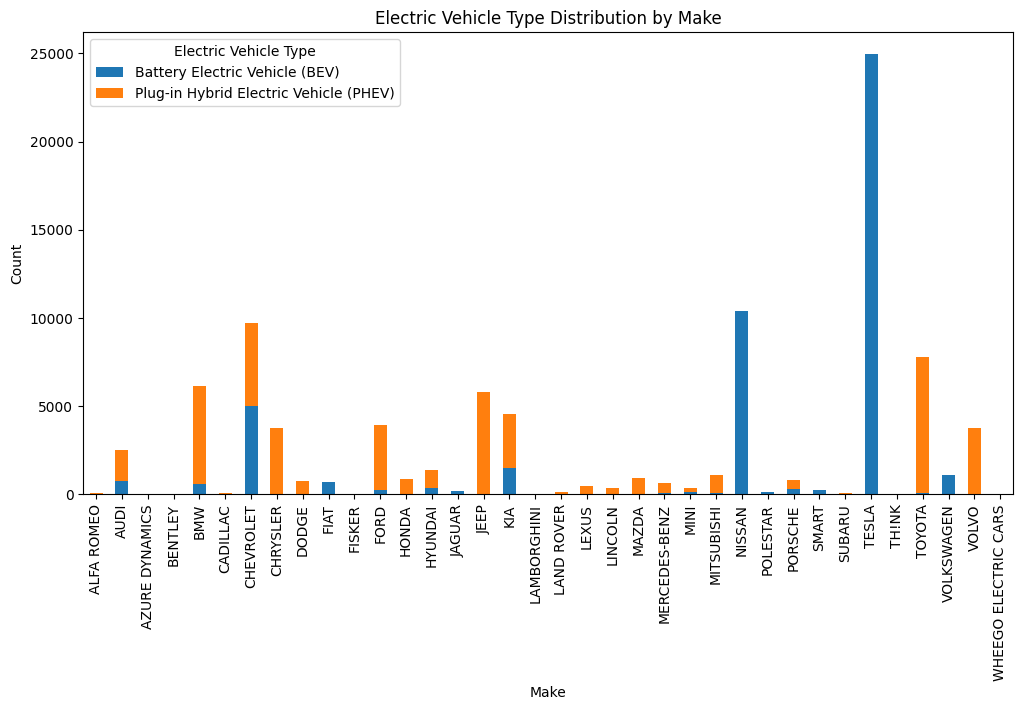

In [14]:
plt.figure(figsize=(12, 6))
df_filtered.groupby(["Make", "Electric Vehicle Type"]).size().unstack().plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Electric Vehicle Type Distribution by Make")
plt.xlabel("Make")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Electric Vehicle Type")
plt.show()

<Figure size 1200x600 with 0 Axes>

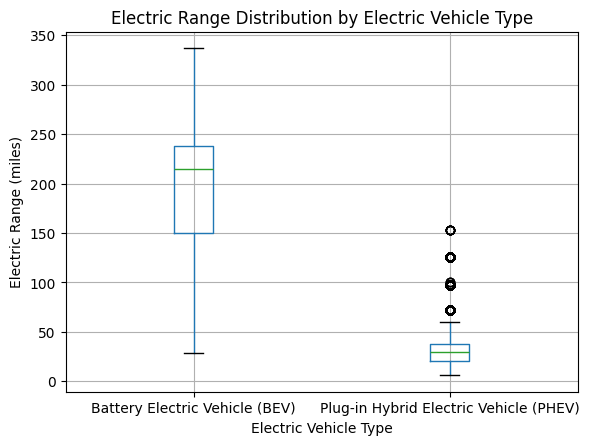

In [15]:
plt.figure(figsize=(12, 6))
df_filtered.boxplot(column="Electric Range", by="Electric Vehicle Type")
plt.title("Electric Range Distribution by Electric Vehicle Type")
plt.xlabel("Electric Vehicle Type")
plt.ylabel("Electric Range (miles)")
plt.suptitle("")
plt.show()

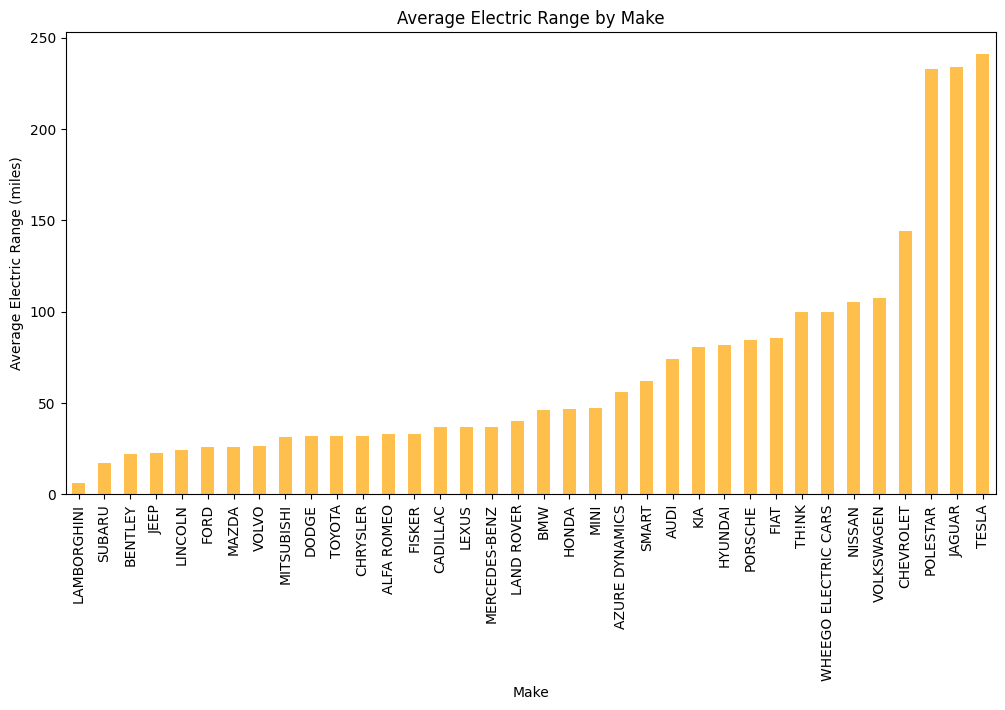

In [16]:
top_makes = df_filtered["Make"].value_counts().index
df_make_avg_range = df_filtered[df_filtered["Make"].isin(top_makes)].groupby("Make")["Electric Range"].mean().sort_values()

# Bar chart for average electric range by make
plt.figure(figsize=(12, 6))
df_make_avg_range.plot(kind="bar", color="orange", alpha=0.7)
plt.title("Average Electric Range by Make")
plt.xlabel("Make")
plt.ylabel("Average Electric Range (miles)")
plt.xticks(rotation=90)
plt.show()

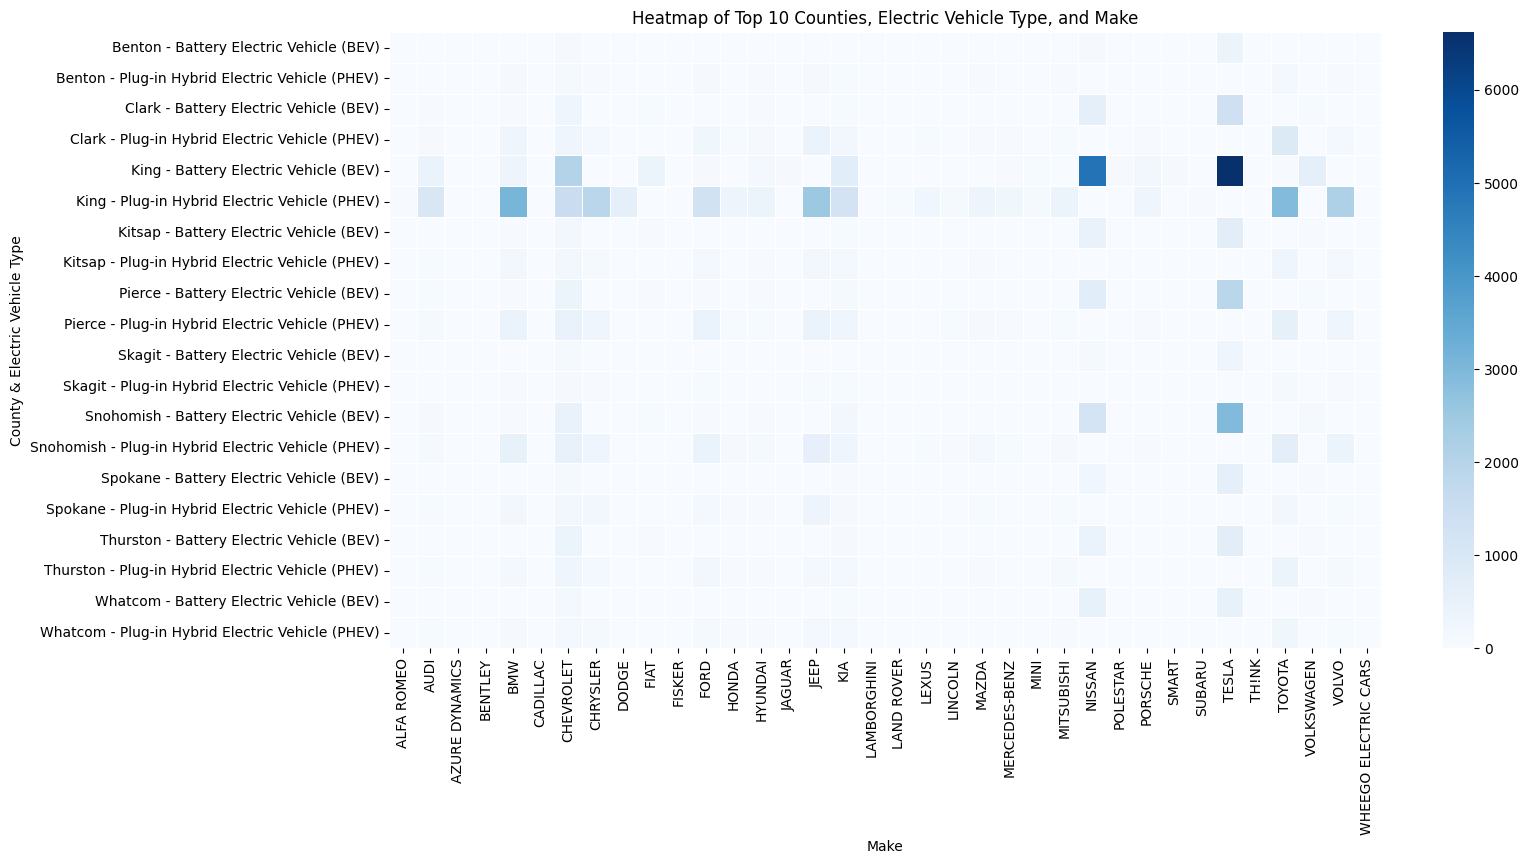

In [17]:
# Creating a more readable heatmap with county names properly displayed

# Creating a crosstab for the filtered data
top_counties = df_filtered["County"].value_counts().head(10).index
df_top_counties = df_filtered[df_filtered["County"].isin(top_counties)]
crosstab_top = pd.crosstab(index=[df_top_counties["County"], df_top_counties["Electric Vehicle Type"]],
                            columns=df_top_counties["Make"])

# Plot heatmap with better contrast and visible county names
plt.figure(figsize=(16, 8))
ax = sns.heatmap(crosstab_top, cmap="Blues", annot=False, linewidths=0.5, vmax=crosstab_top.max().max()/2)

# Adjusting y-axis to properly display County and Vehicle Type labels
ax.set_yticklabels([f"{idx[0]} - {idx[1]}" for idx in crosstab_top.index], rotation=0, fontsize=10)

plt.title("Heatmap of Top 10 Counties, Electric Vehicle Type, and Make")
plt.xlabel("Make")
plt.ylabel("County & Electric Vehicle Type")
plt.xticks(rotation=90)
plt.show()


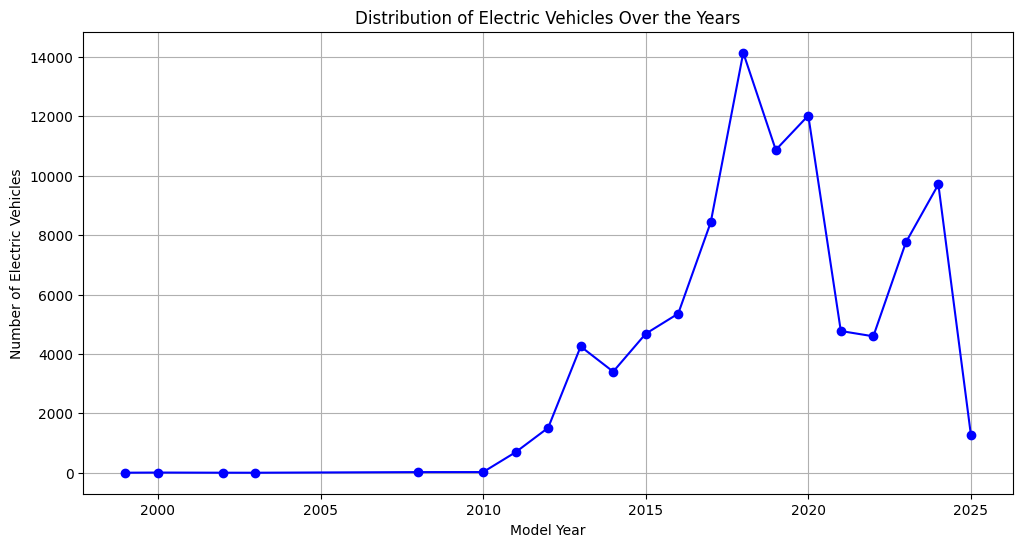

In [18]:
# Creating a line graph for the distribution of electric vehicles over the years
plt.figure(figsize=(12, 6))

# Count of vehicles per model year
ev_yearly_count = df_filtered["Model Year"].value_counts().sort_index()

# Plot line graph
plt.plot(ev_yearly_count.index, ev_yearly_count.values, marker="o", linestyle="-", color="b")

# Labels and title
plt.xlabel("Model Year")
plt.ylabel("Number of Electric Vehicles")
plt.title("Distribution of Electric Vehicles Over the Years")
plt.grid(True)
plt.show()


In [19]:
correlation_matrix = df_filtered.corr(numeric_only=True)
df_filtered_encoded = df_filtered.copy()
df_filtered_encoded["Electric Vehicle Type"] = df_filtered_encoded["Electric Vehicle Type"].astype("category").cat.codes

correlation_matrix_with_target = df_filtered_encoded.corr(numeric_only=True)["Electric Vehicle Type"].abs().sort_values(ascending=True)

uncorrelated_features = correlation_matrix_with_target.head(5)
uncorrelated_features


Postal Code             0.002161
2020 Census Tract       0.009054
Base MSRP               0.056780
DOL Vehicle ID          0.080316
Legislative District    0.090517
Name: Electric Vehicle Type, dtype: float64

In [20]:
features_to_drop = ["Postal Code", "2020 Census Tract", "Base MSRP", "DOL Vehicle ID", "Legislative District"]
df_reduced = df_filtered.drop(columns=features_to_drop)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


# Identify categorical columns
categorical_columns = df_reduced.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_reduced[col] = le.fit_transform(df_reduced[col].astype(str))
    label_encoders[col] = le  # Store encoders for possible inverse transformation

# Save the label-encoded dataset as a CSV file
df_reduced.to_csv("Label_Encoded_Dataset.csv", index=False)

numerical_columns = [ "Electric Range"]  # Add other numerical columns if necessary

# Find Min & Max values (for reference)
min_max_values = df_reduced[numerical_columns].agg(["min", "max"])
print("Min & Max Values:\n", min_max_values)

# Apply Min-Max Normalization (Scaling values between 0 and 1)
scaler = MinMaxScaler()
df_reduced[numerical_columns] = scaler.fit_transform(df_reduced[numerical_columns])
df_reduced.to_csv("Normalized_Dataset.csv", index=False)


Min & Max Values:
      Electric Range
min             6.0
max           337.0


In [21]:


df = pd.read_csv("Normalized_Dataset.csv")  # Ensure the correct dataset is used

target_column = "Electric Vehicle Type"

# Splitting features (X) and target variable (y)
X = df.drop(columns=[target_column])  # Features
X=df[['VIN (1-10)','County', 'City', 'State',"Model Year","Make","Model","Electric Range","Electric Utility"]]
y = df[target_column]  # Target

# Splitting into Training (70%), Validation (15%), and Testing (15%) Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Print dataset sizes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Testing Set: {X_test.shape}")

# Save split datasets for future use
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Training Set (X_train):")
print(X_train.head(), "\n")

print("Training Labels (y_train):")
print(y_train.head(), "\n")

print("Validation Set (X_val):")
print(X_val.head(), "\n")

print("Validation Labels (y_val):")
print(y_val.head(), "\n")

print("Testing Set (X_test):")
print(X_test.head(), "\n")

print("Testing Labels (y_test):")
print(y_test.head(), "\n")

Training Set: (65474, 9), Validation Set: (14030, 9), Testing Set: (14031, 9)
Training Set (X_train):
       VIN (1-10)  County  City  State  Model Year  Make  Model  \
83535        2915      60   447     38        2020    30     55   
64540        2507     100   198     38        2014    30     53   
84486        7176      60   320     38        2024    34     96   
54220        3596     100   198     38        2025    19     57   
311          2155      60   498     38        2019    30     52   

       Electric Range  Electric Utility  
83535        0.861027                71  
64540        0.610272                18  
84486        0.087613                71  
54220        0.093656                18  
311          0.646526                54   

Training Labels (y_train):
83535    0
64540    0
84486    1
54220    1
311      0
Name: Electric Vehicle Type, dtype: int64 

Validation Set (X_val):
       VIN (1-10)  County  City  State  Model Year  Make  Model  \
81818        2932      6


🔹 Logistic Regression Results:
Accuracy: 0.9871
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      7007
           1       0.98      0.99      0.99      7024

    accuracy                           0.99     14031
   macro avg       0.99      0.99      0.99     14031
weighted avg       0.99      0.99      0.99     14031

Confusion Matrix:
 [[6889  118]
 [  63 6961]]
Training Time: 1.0559 seconds

🔹 KNN Results:
Accuracy: 0.9880
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7007
           1       0.99      0.99      0.99      7024

    accuracy                           0.99     14031
   macro avg       0.99      0.99      0.99     14031
weighted avg       0.99      0.99      0.99     14031

Confusion Matrix:
 [[6905  102]
 [  66 6958]]
Training Time: 0.1463 seconds

🔹 Naive Bayes Results:
Accuracy: 0.9688
Classification Report:


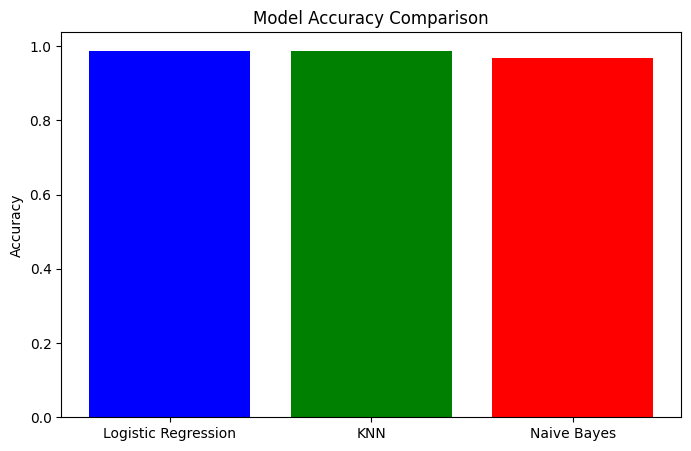

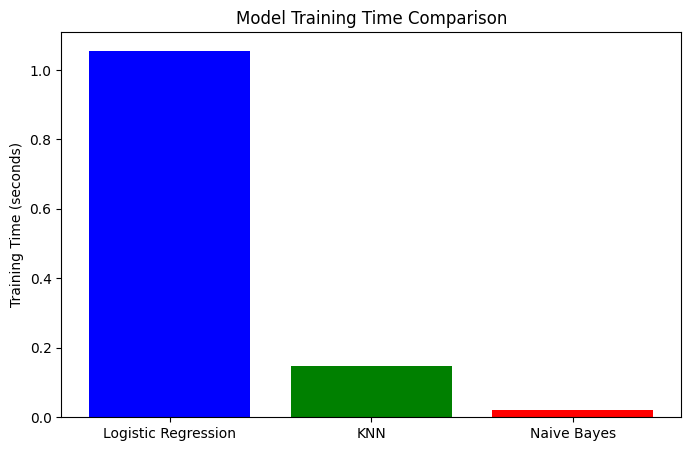

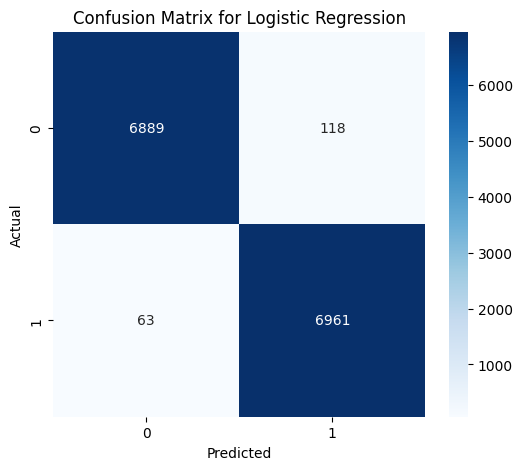

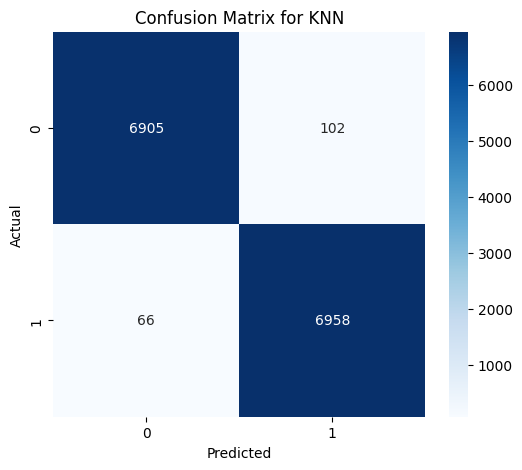

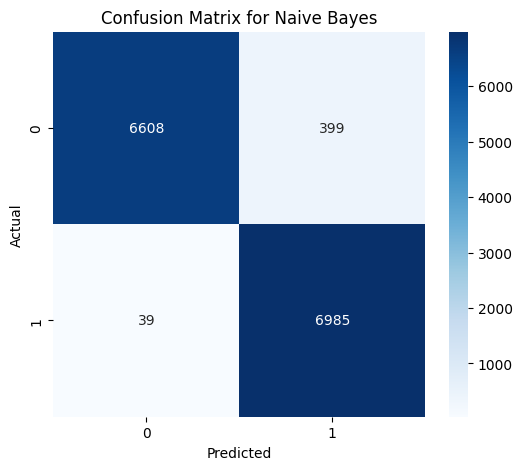

In [22]:


model_results = {}

### **1️⃣ Logistic Regression**
start = time.time()
log_reg = LogisticRegression(C=1.0, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
end = time.time()
y_pred_log = log_reg.predict(X_test)

# Store results
model_results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Classification Report": classification_report(y_test, y_pred_log),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_log),
    "Training Time": end - start,
    "Predictions": y_pred_log
}

### **2️⃣ KNN (K-Nearest Neighbors)**
start = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
end = time.time()
y_pred_knn = knn.predict(X_test)

# Store results
model_results["KNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Classification Report": classification_report(y_test, y_pred_knn),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_knn),
    "Training Time": end - start,
    "Predictions": y_pred_knn
}

### **3️⃣ Naive Bayes**
start = time.time()
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
end = time.time()
y_pred_nb = naive_bayes.predict(X_test)

# Store results
model_results["Naive Bayes"] = {
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Classification Report": classification_report(y_test, y_pred_nb),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_nb),
    "Training Time": end - start,
    "Predictions": y_pred_nb
}

# Print results for each model
for model_name, results in model_results.items():
    print(f"\n🔹 {model_name} Results:")
    print(f"Accuracy: {results['Accuracy']:.4f}")
    print("Classification Report:\n", results["Classification Report"])
    print("Confusion Matrix:\n", results["Confusion Matrix"])
    print(f"Training Time: {results['Training Time']:.4f} seconds")

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Accuracy"] for results in model_results.values()], color=['blue', 'green', 'red'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

# Plot training time comparison
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Training Time"] for results in model_results.values()], color=['blue', 'green', 'red'])
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.show()

# Plot confusion matrices
for model_name, results in model_results.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()



🔹 Logistic Regression Results:
Accuracy: 0.9871
Loss: 0.0555
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      7007
           1       0.98      0.99      0.99      7024

    accuracy                           0.99     14031
   macro avg       0.99      0.99      0.99     14031
weighted avg       0.99      0.99      0.99     14031

Confusion Matrix:
 [[6889  118]
 [  63 6961]]
Training Time: 1.0559 seconds

🔹 KNN Results:
Accuracy: 0.9880
Loss: 0.0613
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7007
           1       0.99      0.99      0.99      7024

    accuracy                           0.99     14031
   macro avg       0.99      0.99      0.99     14031
weighted avg       0.99      0.99      0.99     14031

Confusion Matrix:
 [[6905  102]
 [  66 6958]]
Training Time: 0.1463 seconds

🔹 Naive Bayes Results:
Accuracy: 0.96

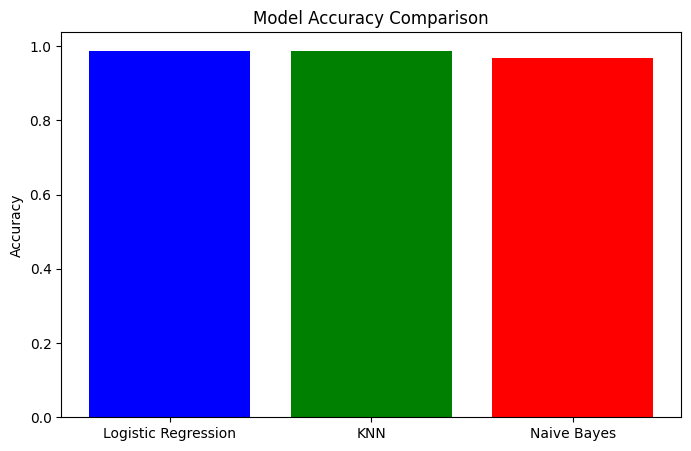

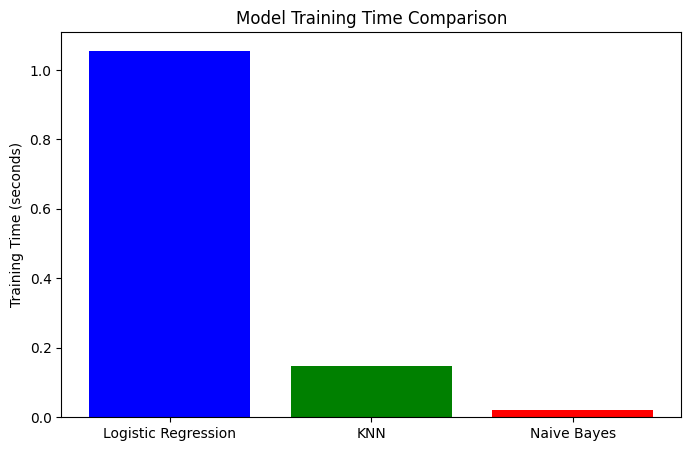

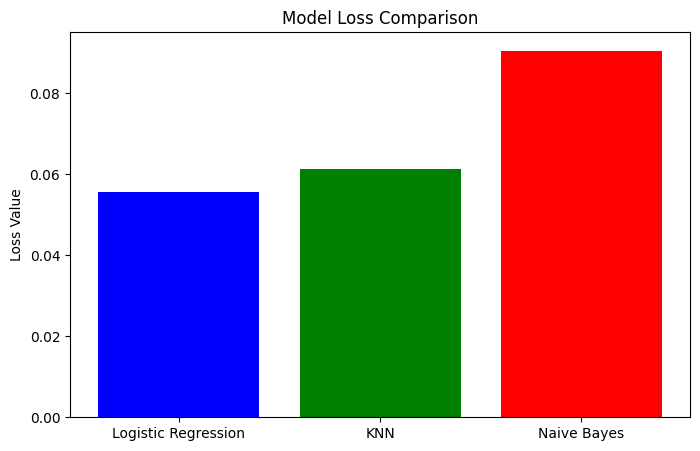

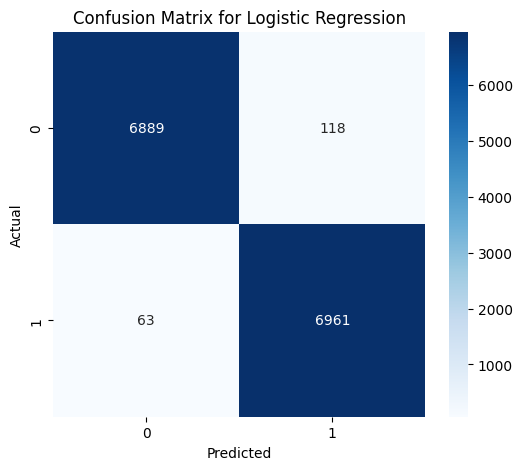

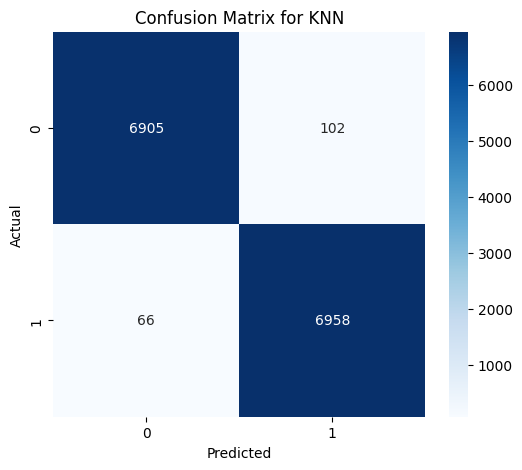

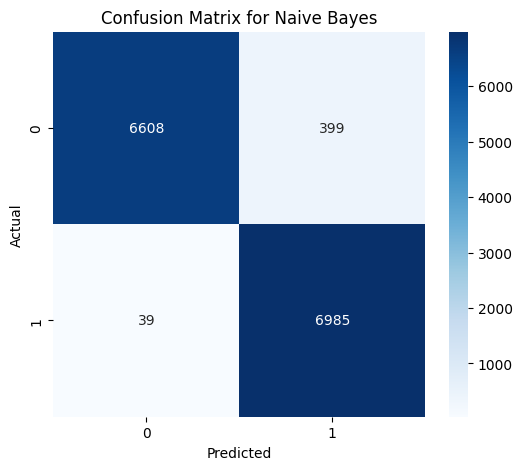

In [23]:
from sklearn.metrics import log_loss

# Compute loss for Logistic Regression
log_loss_value_log = log_loss(y_test, log_reg.predict_proba(X_test))
model_results["Logistic Regression"]["Loss"] = log_loss_value_log

# Compute loss for KNN (by approximating probabilities using predict_proba if available)
if hasattr(knn, "predict_proba"):
    log_loss_value_knn = log_loss(y_test, knn.predict_proba(X_test))
    model_results["KNN"]["Loss"] = log_loss_value_knn

# Compute loss for Naive Bayes
log_loss_value_nb = log_loss(y_test, naive_bayes.predict_proba(X_test))
model_results["Naive Bayes"]["Loss"] = log_loss_value_nb

# Print updated results including loss values
for model_name, results in model_results.items():
    print(f"\n🔹 {model_name} Results:")
    print(f"Accuracy: {results['Accuracy']:.4f}")
    if "Loss" in results:
        print(f"Loss: {results['Loss']:.4f}")
    print("Classification Report:\n", results["Classification Report"])
    print("Confusion Matrix:\n", results["Confusion Matrix"])
    print(f"Training Time: {results['Training Time']:.4f} seconds")

# Display accuracy comparison chart
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Accuracy"] for results in model_results.values()], color=['blue', 'green', 'red'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

# Display training time comparison chart
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Training Time"] for results in model_results.values()], color=['blue', 'green', 'red'])
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.show()

# Display loss comparison chart (if available)
plt.figure(figsize=(8, 5))
plt.bar([key for key in model_results.keys() if "Loss" in model_results[key]],
        [results["Loss"] for results in model_results.values() if "Loss" in results],
        color=['blue', 'green', 'red'])
plt.ylabel("Loss Value")
plt.title("Model Loss Comparison")
plt.show()

# Display confusion matrices
for model_name, results in model_results.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [24]:




# Encode target labels
y_train_encoded = LabelEncoder().fit_transform(y_train)
y_test_encoded = LabelEncoder().fit_transform(y_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

# Define Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, 16)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(16, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.relu4(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Initialize model
input_size = X_train_scaled.shape[1]
output_size = len(np.unique(y_train_encoded))
model = NeuralNetwork(input_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
start = time.time()
epochs = 50
best_accuracy = 0.0
best_model_path = "best_model.pth"
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluate model
    with torch.no_grad():
        y_pred_train = torch.argmax(model(X_train_tensor), axis=1).numpy()
        train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch+1}: New best model saved with accuracy {best_accuracy:.4f}")

end = time.time()

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Predict on test set
with torch.no_grad():
    y_pred_nn = torch.argmax(model(X_test_tensor), axis=1).numpy()

# Store results
model_results["Neural Network"] = {
    "Accuracy": accuracy_score(y_test_encoded, y_pred_nn),
    "Classification Report": classification_report(y_test_encoded, y_pred_nn),
    "Confusion Matrix": confusion_matrix(y_test_encoded, y_pred_nn),
    "Training Time": end - start,
    "Predictions": y_pred_nn
}



print("\n🔹 Neural Network Results:")
print(f"Accuracy: {model_results['Neural Network']['Accuracy']:.4f}")
print("Classification Report:\n", model_results['Neural Network']['Classification Report'])
print("Confusion Matrix:\n", model_results['Neural Network']['Confusion Matrix'])
print(f"Training Time: {model_results['Neural Network']['Training Time']:.4f} seconds")


Epoch 1: New best model saved with accuracy 0.9840
Epoch 2: New best model saved with accuracy 0.9899
Epoch 3: New best model saved with accuracy 0.9914
Epoch 4: New best model saved with accuracy 0.9933
Epoch 5: New best model saved with accuracy 0.9935
Epoch 6: New best model saved with accuracy 0.9937
Epoch 8: New best model saved with accuracy 0.9940
Epoch 9: New best model saved with accuracy 0.9944
Epoch 10: New best model saved with accuracy 0.9945
Epoch 11: New best model saved with accuracy 0.9947
Epoch 12: New best model saved with accuracy 0.9949
Epoch 17: New best model saved with accuracy 0.9953
Epoch 18: New best model saved with accuracy 0.9956
Epoch 25: New best model saved with accuracy 0.9957
Epoch 29: New best model saved with accuracy 0.9959
Epoch 33: New best model saved with accuracy 0.9962
Epoch 36: New best model saved with accuracy 0.9965
Epoch 38: New best model saved with accuracy 0.9966
Epoch 39: New best model saved with accuracy 0.9967
Epoch 40: New best m

<ipython-input-24-7a7c34cad3f2>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch 1/50 - Loss: 0.3160, Accuracy: 0.9971
Epoch 2/50 - Loss: 0.3158, Accuracy: 0.9970
Epoch 3/50 - Loss: 0.3160, Accuracy: 0.9978
Epoch 4/50 - Loss: 0.3157, Accuracy: 0.9974
Epoch 5/50 - Loss: 0.3161, Accuracy: 0.9972
Epoch 6/50 - Loss: 0.3159, Accuracy: 0.9965
Epoch 7/50 - Loss: 0.3160, Accuracy: 0.9976
Epoch 8/50 - Loss: 0.3157, Accuracy: 0.9978
Epoch 9/50 - Loss: 0.3156, Accuracy: 0.9977
Epoch 10/50 - Loss: 0.3157, Accuracy: 0.9978
Epoch 11/50 - Loss: 0.3155, Accuracy: 0.9976
Epoch 12/50 - Loss: 0.3154, Accuracy: 0.9979
Epoch 13/50 - Loss: 0.3154, Accuracy: 0.9977
Epoch 14/50 - Loss: 0.3154, Accuracy: 0.9981
Epoch 15/50 - Loss: 0.3157, Accuracy: 0.9975
Epoch 16/50 - Loss: 0.3156, Accuracy: 0.9979
Epoch 17/50 - Loss: 0.3153, Accuracy: 0.9978
Epoch 18/50 - Loss: 0.3155, Accuracy: 0.9978
Epoch 19/50 - Loss: 0.3153, Accuracy: 0.9979
Epoch 20/50 - Loss: 0.3154, Accuracy: 0.9973
Epoch 21/50 - Loss: 0.3157, Accuracy: 0.9978
Epoch 22/50 - Loss: 0.3158, Accuracy: 0.9964
Epoch 23/50 - Loss:

<ipython-input-25-f2301fe036bc>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


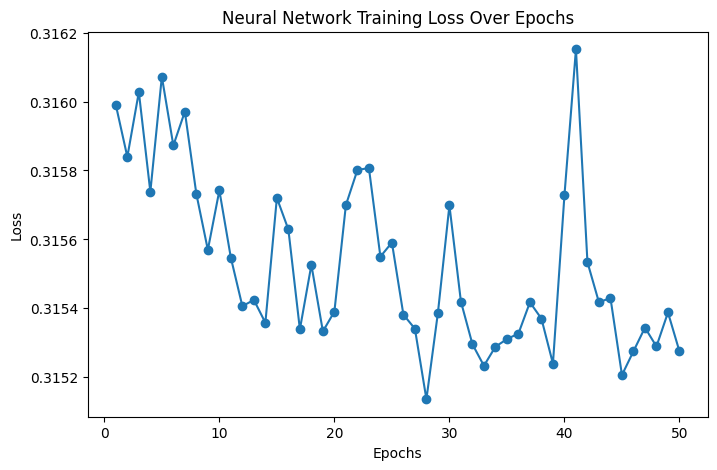

In [25]:
# Modify the Neural Network training loop to print loss values for each epoch

# Train the model with loss tracking
start = time.time()
epochs = 50
best_accuracy = 0.0
best_model_path = "best_model.pth"
loss_values = []  # Store loss values for each epoch

for epoch in range(epochs):
    epoch_loss = 0.0  # Accumulate loss per epoch
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # Sum loss for the epoch

    avg_loss = epoch_loss / len(train_loader)  # Average loss per epoch
    loss_values.append(avg_loss)  # Store loss value

    # Evaluate model
    with torch.no_grad():
        y_pred_train = torch.argmax(model(X_train_tensor), axis=1).numpy()
        train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

end = time.time()

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Predict on test set
with torch.no_grad():
    y_pred_nn = torch.argmax(model(X_test_tensor), axis=1).numpy()

# Store results including the final loss value
model_results["Neural Network"] = {
    "Accuracy": accuracy_score(y_test_encoded, y_pred_nn),
    "Loss": loss_values[-1],  # Last epoch's loss
    "Classification Report": classification_report(y_test_encoded, y_pred_nn),
    "Confusion Matrix": confusion_matrix(y_test_encoded, y_pred_nn),
    "Training Time": end - start,
    "Predictions": y_pred_nn
}

# Print results
print("\n🔹 Neural Network Results:")
print(f"Accuracy: {model_results['Neural Network']['Accuracy']:.4f}")
print(f"Loss: {model_results['Neural Network']['Loss']:.4f}")
print("Classification Report:\n", model_results['Neural Network']['Classification Report'])
print("Confusion Matrix:\n", model_results['Neural Network']['Confusion Matrix'])
print(f"Training Time: {model_results['Neural Network']['Training Time']:.4f} seconds")

# Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Neural Network Training Loss Over Epochs")
plt.show()


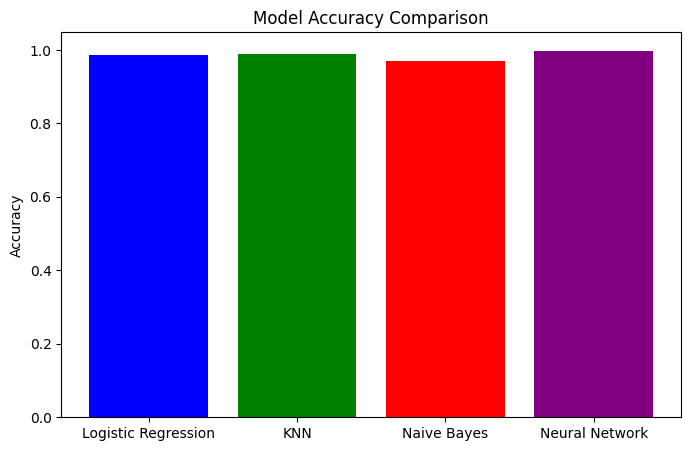

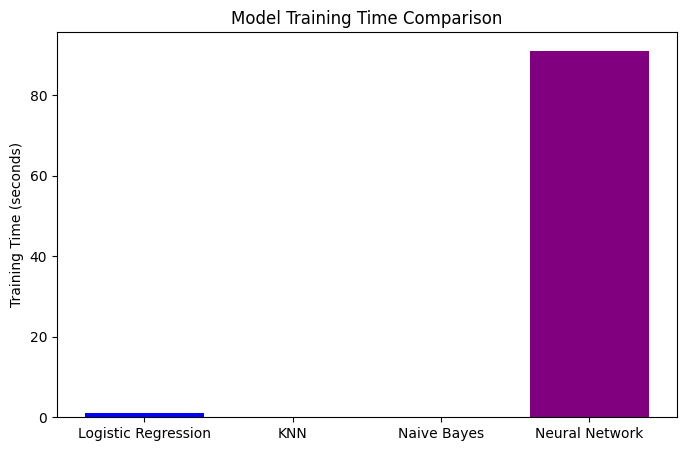

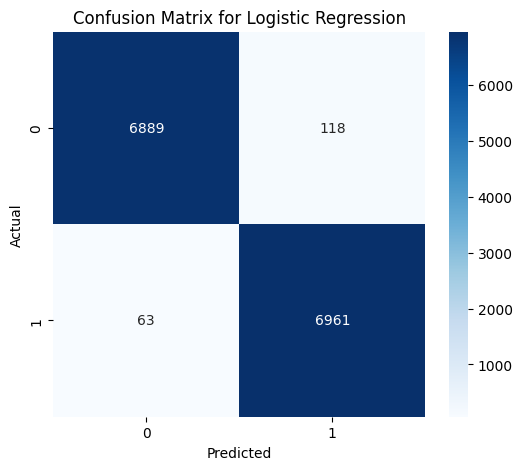

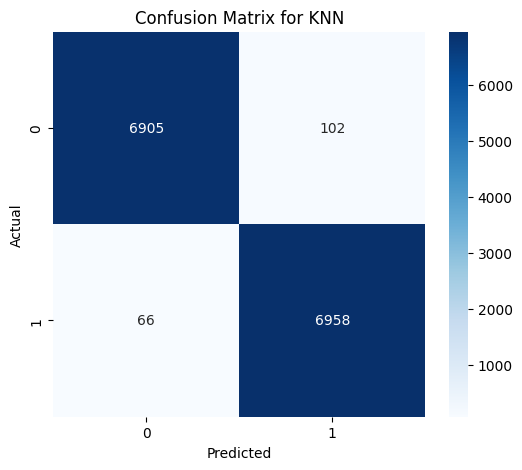

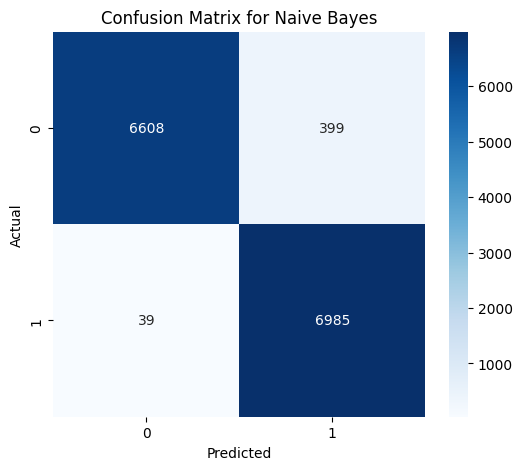

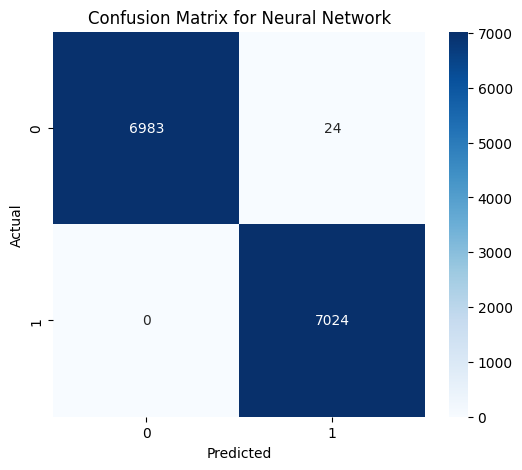

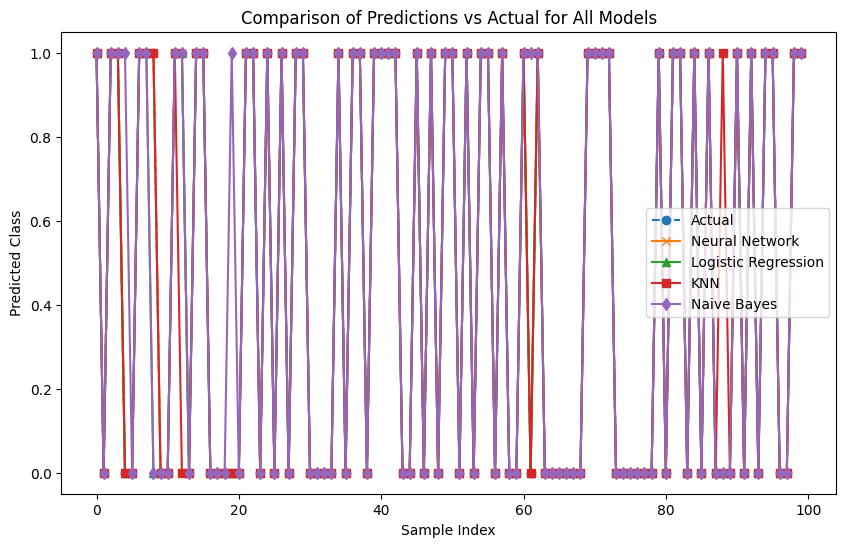

In [26]:


# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Accuracy"] for results in model_results.values()], color=['blue', 'green', 'red', 'purple'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

# Plot training time comparison
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), [results["Training Time"] for results in model_results.values()], color=['blue', 'green', 'red', 'purple'])
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.show()

# Plot confusion matrices
for model_name, results in model_results.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Combine predictions vs actual for Neural Network and ML models
plt.figure(figsize=(10, 6))
x_ticks = np.arange(len(y_test_encoded))[:100]  # Plot first 100 samples for clarity
plt.plot(x_ticks, y_test_encoded[:100], label="Actual", marker="o", linestyle="dashed")
plt.plot(x_ticks, model_results["Neural Network"]["Predictions"][:100], label="Neural Network", marker="x")
plt.plot(x_ticks, model_results["Logistic Regression"]["Predictions"][:100], label="Logistic Regression", marker="^")
plt.plot(x_ticks, model_results["KNN"]["Predictions"][:100], label="KNN", marker="s")
plt.plot(x_ticks, model_results["Naive Bayes"]["Predictions"][:100], label="Naive Bayes", marker="d")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Class")
plt.title("Comparison of Predictions vs Actual for All Models")
plt.legend()
plt.show()
